# This notebook contains preliminary results

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from tabulate import tabulate # Have to dowload this on laptop
# print(tabulate(df_baselines_edited[(df_baselines_edited.Diagnosis == 1)].describe().round(3),tablefmt="grid", headers='keys'))
from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess_baseline import (reference_sentences,
                                           calculate_iki_and_ed_baseline,
                                           calculate_all_baseline_ROC_curves,
                                           convert_df_to_subject_level,
                                           get_X_and_y_from_df,
                                           test_different_splits_for_classification)

from haberrspd.plotting import plot_roc_curve_simple, plot_superimposed_roc_curves, nice_fonts
import pandas as pd
import numpy as np

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib as mpl
import matplotlib.pyplot as plt

# Settings for plotting

# plt.style.use('dark_background')
# Set to default again
# plt.rcParams.update(plt.rcParamsDefault)
# mpl.rcParams.update(nice_fonts)

To do:

1. Change the percentile calculation (use np.percentile()) and then use the fitted model for the replacement value
2. Change Percenttile value for MJFF and MRC IKI replacements
3. Run results for Spanish data as well (download the meta file as well)
    1. Load raw
    2. Clean with baseline methods
    3. Filter and replace IKI outliers
4. Calculate summary stats for MRC for subjects and controls (check dist for IKI)
5. Eventually re-do total compression time per key i.e. order keydown/keyup

# Baseline classifiers

---

## MJFF [english: sentence level]

In [18]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

In [19]:
which_attempt = 1

df_baselines_raw = calculate_iki_and_ed_baseline(df=df,
                                                 df_meta=df_meta,
                                                 drop_shift=False,
                                                 attempt=which_attempt,
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df=df,
                                                    df_meta=df_meta,
                                                    drop_shift=False,
                                                    attempt=which_attempt,
                                                    invokation_type=1) # Error corrections have been made

MJFF
MJFF


In [25]:
print(tabulate(df_baselines_raw[(df_baselines_raw.Diagnosis == 0)].describe(),tablefmt="grid", headers='keys'))

+-------+---------------+-------------+------------+-----------+-----------------+
|       |   Sentence_ID |   Diagnosis |   Mean_IKI |   Var_IKI |   Edit_Distance |
+=======+===============+=============+============+===========+=================+
| count |     741       |         741 |    741     |    741    |        741      |
+-------+---------------+-------------+------------+-----------+-----------------+
| mean  |      61.9811  |           0 |    314.472 |  63608.4  |        105.71   |
+-------+---------------+-------------+------------+-----------+-----------------+
| std   |       4.32525 |           0 |    101.504 |  39685.5  |         99.1941 |
+-------+---------------+-------------+------------+-----------+-----------------+
| min   |      55       |           0 |    120.333 |   2696.31 |          0      |
+-------+---------------+-------------+------------+-----------+-----------------+
| 25%   |      58       |           0 |    239.92  |  35593.8  |         54      |
+---

In [ ]:
print(df_baselines_raw.Edit_Distance.var())
print(df_baselines_edited.Edit_Distance.var())

out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [ ]:
plot_superimposed_roc_curves([out1,out2],
                             'mjff_attempt_' + str(which_attempt) +'_sentence_level_rfc')

## MRC [sentence level]

In [2]:
df = pd.read_pickle(Path('../data/MRC/') / 'cleaned_mrc.pkl')

### Drop all shift keys

In [ ]:
df_baselines_raw = calculate_iki_and_ed_baseline(df, 
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(Path('../data/MRC/') / 'cleaned_mrc.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df, 
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

In [15]:
df_baselines_edited[(df_baselines_edited.Diagnosis == 1)].describe().round(3)

,Patient_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI,Edit_Distance
count,1171.000,1171.000,1171.0,1171.000,1171.000,1171.000
mean,66.368,7.974,1.0,305.941,45139.622,9.414
std,30.505,4.331,0.0,107.132,33551.116,6.648
min,11.000,1.000,1.0,126.777,2694.736,2.000
25%,41.000,4.000,1.0,232.583,22402.246,6.000
50%,64.000,8.000,1.0,280.203,35086.575,8.000
75%,92.000,12.000,1.0,346.834,58336.280,12.000
max,119.000,15.000,1.0,777.165,235131.319,115.000


In [16]:
df_baselines_edited[(df_baselines_edited.Diagnosis == 0)].describe().round(3)

,Patient_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI,Edit_Distance
count,1870.000,1870.000,1870.0,1870.000,1870.000,1870.000
mean,1088.271,7.972,0.0,296.277,50666.992,8.066
std,46.871,4.317,0.0,110.300,39072.005,4.690
min,1010.000,1.000,0.0,2.878,712.646,2.000
25%,1047.000,4.000,0.0,215.389,21424.663,5.000
50%,1086.000,8.000,0.0,275.422,40733.607,7.000
75%,1131.000,12.000,0.0,346.692,68614.975,10.000
max,1167.000,15.000,0.0,720.407,279774.101,47.000


In [17]:
out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

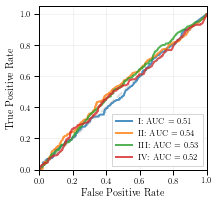

In [18]:
# For reasons unknown we can only run this once...
plot_superimposed_roc_curves([out1,out2],'mrc_with_dropped_shift_keys_sentence_level')

### Shift keys are kept

In [3]:
df_baselines_raw = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)], 
                                                 drop_shift=False, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(Path('../data/MRC/') / 'cleaned_mrc.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                    drop_shift=False,
                                                    invokation_type=1) # Error corrections have been made

MRC

 Pickled file wasn't found.


/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MRC

 Pickled file wasn't found.


/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw, n_reruns=10)
b = calculate_all_baseline_ROC_curves(df_baselines_edited, n_reruns=10)

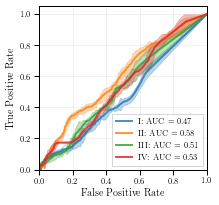

In [58]:
# mrc_shift_keys_kept_sentence_level
plot_superimposed_roc_curves([a,b],'test')

### MJFF [subject level]

In [ ]:
df_baselines_raw.head()

In [ ]:
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j,test_different_splits_for_classification(outs[j]))

### MRC [subject level]

In [20]:
def get_X_and_y_from_df(df):

    measures = ["Edit_Distance", "Mean_IKI", "Diagnosis"]
    # assert set(measures).issubset(df.columns)
    features = ["Mean_IKI", ["Edit_Distance", "Mean_IKI"]]

    # Store all results in a dict which will be passed to plotting
    sets = {"I": None, "II": None}
    # assert len(sets) == len(features)
    for i, j in zip(features, sets.keys()):
        
        # List of features
        if isinstance(i, list):
            assert len(i) == 2
            X = []
            for k in range(df.shape[0]):
                X.append(df.loc[k,i[0]] + df.loc[k,i[1]])
            X = np.vstack(X)
            
        # Singular feature
        else:
            X = np.vstack(df[i])

        # targets
        y = df.Diagnosis.to_numpy()

        sets[j] = (X, y)

    return sets

In [21]:
part = convert_df_to_subject_level(df_baselines_raw)

In [22]:
# out = convert_df_to_subject_level(df_baselines_raw)
outs = get_X_and_y_from_df(part)

In [23]:
# We use the version with shift keys kept
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j, test_different_splits_for_classification(outs[j]))

I (0.787, 0.067)
II (0.952, 0.022)
I (0.797, 0.053)
II (0.981, 0.015)



I (0.791, 0.047)
II (0.947, 0.027)
I (0.789, 0.062)
II (0.976, 0.016)

# Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [24]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



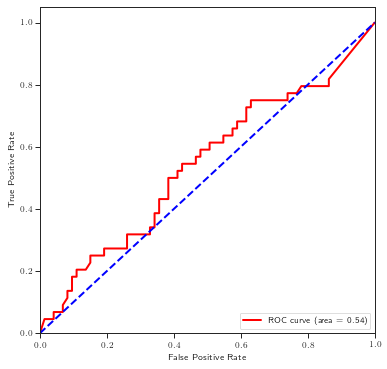

Number of hyperparameter permutations considered: 200



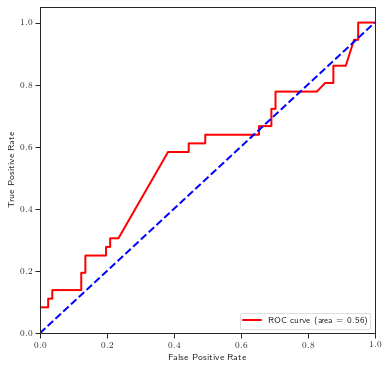

Number of hyperparameter permutations considered: 500



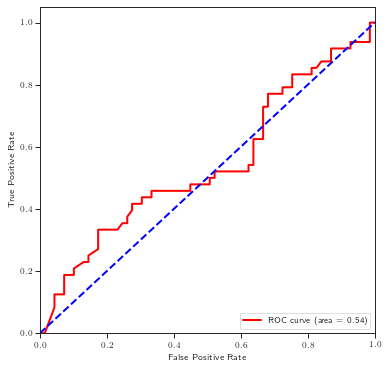

In [25]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

In [ ]:
plot_roc_curve_simple(char[200][:,0].astype(np.int64), char[200][:,1],'mjff_char_only')

# CHARACTERS and TIME

In [26]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



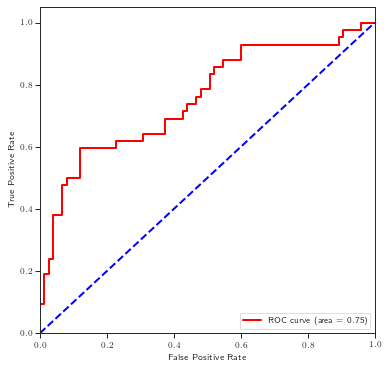

Number of hyperparameter permutations considered: 200



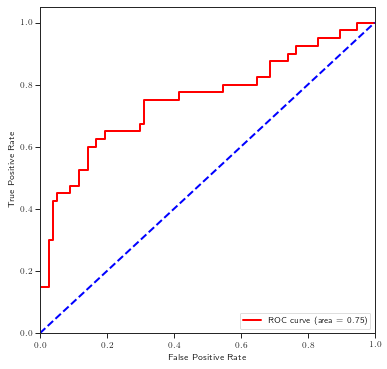

Number of hyperparameter permutations considered: 500



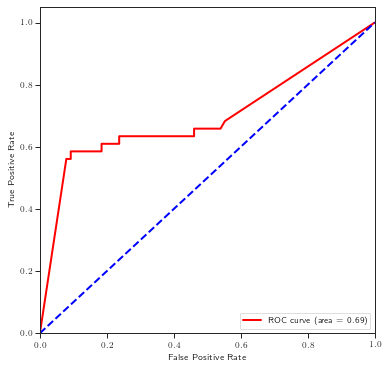

In [27]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time[200][:,0].astype(np.int64), char_time[200][:,1],'mjff_char_time')

# CHARACTERS and TIME and Space

In [28]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



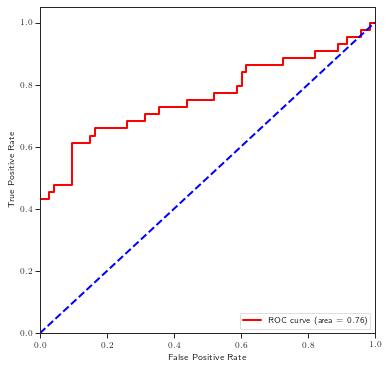

Number of hyperparameter permutations considered: 500



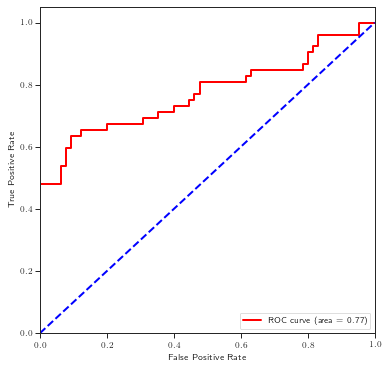

In [29]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time_space[500][:,0].astype(np.int64), char_time_space[500][:,1],'mjff_char_time_space')

In [ ]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [ ]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

In [ ]:
# Detailed look at the "winning model"
df.iloc[387,:]